### check phase precession of a hd cell in the model

In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
from Network_models import HD_cell
from plotFunc import get_HDtuningMap
#gridspec
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu

bm.set_platform('cpu')
# simulation time step
bm.set_dt(1.)

In [2]:
def circular_gaussian(x, a, x0, sigma, b):
    """Circular Gaussian function."""
    return a * np.exp(-((x - x0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * sigma**2)) + b

def fit_circular_gaussian(tuning_map, x):
    """Fit a circular Gaussian to the tuning map."""
    initial_guess = [np.max(tuning_map), np.argmax(tuning_map) * (2 * np.pi / len(tuning_map)), 1, np.min(tuning_map)]  # Initial guesses for a, x0, sigma, b
    popt, _ = curve_fit(circular_gaussian, x, tuning_map, p0=initial_guess, bounds=(0, np.inf))
    return popt

def compute_gaussian_width(tuning_map):
    """Compute the width of the Gaussian bump on a circular vector."""
    x = np.linspace(0, 2 * np.pi, len(tuning_map), endpoint=False)
    popt = fit_circular_gaussian(tuning_map, x)
    sigma = popt[2]
    width = 4 * sigma
    return width, popt

def compute_autocorrelation(fr_array, bin_size=0.001, max_lag=0.5):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(fr_array, fr_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    idx_range = np.where((lags >= 0.05) & (lags <= 0.25))[0]
    max_value = np.max(autocorr[idx_range])
    autocorr = autocorr / max_value
    autocorr = np.clip(autocorr, a_min=None, a_max=1)  # Clip values above 1
    
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])

def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    autocorr = np.correlate(signal - mean, signal - mean, mode='full') / (var * n)
    return autocorr

def calculate_skipping_index(autocorrelogram):
    def model(t, a1, a2, b, c, omega, t1, t2):
        return (a1 * (np.cos(omega * t) + 1) + a2 * (np.cos(0.5 * omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * np.pi * 8, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, -1, 10 * np.pi, 0, 0], [1, 1, 1, 1, 18 * np.pi, 5., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(model, lags, autocorr, p0=initial_guess, bounds=bounds)
    a1, a2, b, c, omega, t1, t2 = params

    # Calculate p1 and p2
    p1 = model(2 * np.pi / omega, *params)
    p2 = model(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    # print(f"Intrinsic Theta Frequency: {omega / (2 * np.pi):.2f} Hz")
    # print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega / (2 * np.pi), TS  # Return frequency in Hz and the TS index

In [3]:
def plot_HDsweep(ax, t, Head_direction, bump_center, max_bump_activity, s_size=5, labelsize=10, ticksize=8):
    ax.plot(t, Head_direction, linewidth=1, color='black', label='Head direction')
    ax.scatter(t, bump_center, c=max_bump_activity, cmap='cool', s=s_size, label='Internal direction')
    ax.legend(loc='upper center', fontsize=ticksize, bbox_to_anchor=(0.5, 1.4), frameon=False)
    ax.set_ylim(-bm.pi, bm.pi)
    
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], t[-1]-t[0]+1])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    #label
    ax.set_xlabel('Time (ms)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_HD_tuningMap(ax, tuningmap, labelsize=10, ticksize=8):
    '''
    Polar plot of the tuning map
    '''
    
    num_hd = len(tuningmap)
    ax.plot(np.linspace(0, 2*np.pi, num_hd), tuningmap, color='#6EC7D6', linewidth=2)
    #get the peak direction of the tuning map on np.linspace(0, 2*np.pi, num_hd)
    peak_direction = np.linspace(0, 2*np.pi, num_hd)[np.argmax(tuningmap)]
    #add as title in degrees as HD_{peak} = peak_direction*180/pi
    # ax.set_title(r'$HD_{peak} = %d\degree$' % (peak_direction*180/np.pi), fontsize=labelsize)


    # Set xticks as 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels([r'$0\degree$', r'$90\degree$', r'$180\degree$', r'$270\degree$'], fontsize=ticksize)
    #moving xticks closer to the plot
    ax.tick_params(axis='x', pad=-1)
    # Hide the y-ticks but keep the grid
    #5 yticks
    ax.set_yticks(np.linspace(0, np.max(tuningmap), 5))
    ax.yaxis.set_tick_params(size=0)  # Set tick size to 0 to hide y-ticks
    ax.set_yticklabels([])
    
    return ax

def plot_phase_precession(ax, cellindex, HD_activity, Head_direction, theta_phase, labelsize=10, ticksize=8):

    hd_spike = []
    tp_spike = []
    #for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
    for i in range(len(Head_direction)):
        hd = Head_direction[i,0]
        tp = theta_phase[i]
        r = HD_activity[i, cellindex] * 2
        #genertae a spike event based on a Poisson process with mean value as r
        spikes = np.random.poisson(r, 1)
        if spikes > 0:
            #save hd and tp
            hd_spike.append(hd)
            tp_spike.append(tp)
    hd_spike = np.array(hd_spike)
    tp_spike = np.array(tp_spike)

    ax.scatter(hd_spike, tp_spike, s=3, color='black', alpha=0.1)

    ax.scatter(hd_spike, tp_spike+2*np.pi, s=3, color='black', alpha=0.1)

    #add x=0 line
    ax.axvline(x=0, color='orange', linestyle='--', linewidth=1, label = 'preferred direction')

    ax.legend(loc='upper center', fontsize=ticksize, bbox_to_anchor=(0.5, 1.4), frameon=False)

    # ax[0].set_xlabel('Head direction')
    ax.set_xlabel('Head direction', fontsize=labelsize)
    ax.set_ylabel('Theta phase', fontsize=labelsize)
    #activity colorbar
    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_xticks([-0.5*np.pi, 0, 0.5*np.pi])
    ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$\pi/2$'])
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

    #tick size
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

def plot_autocorrelation(ax, autocorr_r_probe, labelsize=10, ticksize=8):
    
    ax.plot(autocorr_r_probe[1,:], autocorr_r_probe[0,:], color='black', linewidth=1)
    #fill betwwen autocorr_r_probe and np.min(autocorr_r_probe)
    ax.fill_between(autocorr_r_probe[1,:], autocorr_r_probe[0,:], np.min(autocorr_r_probe[0,:]), color='black', alpha=1.0)

    # ax.set_xlim(-500, 500)
    ax.set_ylim(np.min(autocorr_r_probe[0,:]), 1)
    ax.set_yticks([])
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)   
    ax.set_ylabel('')
    ax.set_title('Autocorrelation', fontsize=ticksize)

    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return ax


In [4]:
def run(theta_modulation_stre_hd=0.5, mbar_hd=15, angular_velocity_gain=1, offset=-0.08):

    '''
    0.5, 15, 1: precession HD
    0., 0,, 1: normal HD (no theta tuned)
    3.5, 0, 1: theta tuned no precession 
    '''
    
    num_hd = 100
    noise_stre = 0.1

    HD_net = HD_cell(num=num_hd, 
                    noise_stre=noise_stre, 
                    tau=10., tau_v=100., 
                    k=1., mbar=mbar_hd, a=0.5, A=3.0, J0=4., 
                    z_min=-bm.pi, z_max=bm.pi)

    # run coupled net
    def run_CoupleNet(i, Head_direction):  # 20 x size

        T_theta = 100
        #calculate TheataModulator at time step i
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
        ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
        #calculate internal head direction
        HD_net.step_run(i, Head_direction, ThetaModulator_HD)
        Internal_direction = HD_net.center #center of mass of internal direction
        HD_activity = HD_net.r 

        return Internal_direction, HD_activity, theta_phase

    # run network
    
    angular_velocity = angular_velocity_gain*np.pi/(1e3)
    
    if angular_velocity_gain ==0:
        numT = 4000
        x0 = offset*np.pi
        start = int(3*numT/4)
        end = numT
    else:
        N = 20
        numT = int(N*np.pi/(bm.dt*angular_velocity))
        x0 = -np.pi
        onecycleT = numT/(N/2)
        start = int(numT - 0.7*onecycleT)
        end = int(numT - 0.3*onecycleT)
        
    time_steps = np.arange(numT)

    def traj_hd(x0, v, T):
        x = []
        xt = x0
        for i in range(T):
            xt = xt + v * (1 + np.random.randn(1)) * bm.dt
            if xt > np.pi:
                xt -= 2 * np.pi
            if xt < -np.pi:
                xt += 2 * np.pi
            x.append(xt)
        return np.array(x)

    Head_direction = traj_hd(x0=x0, v=angular_velocity, T=numT)
    # plt.figure()
    # plt.plot(Head_direction)

    center_HD, HD_activity, theta_phase = bm.for_loop(
        run_CoupleNet, (time_steps, Head_direction), progress_bar=True
    )

    theta_phase = theta_phase*2*np.pi
    max_bump_activity = np.max(HD_activity, axis=1)
    
    return start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

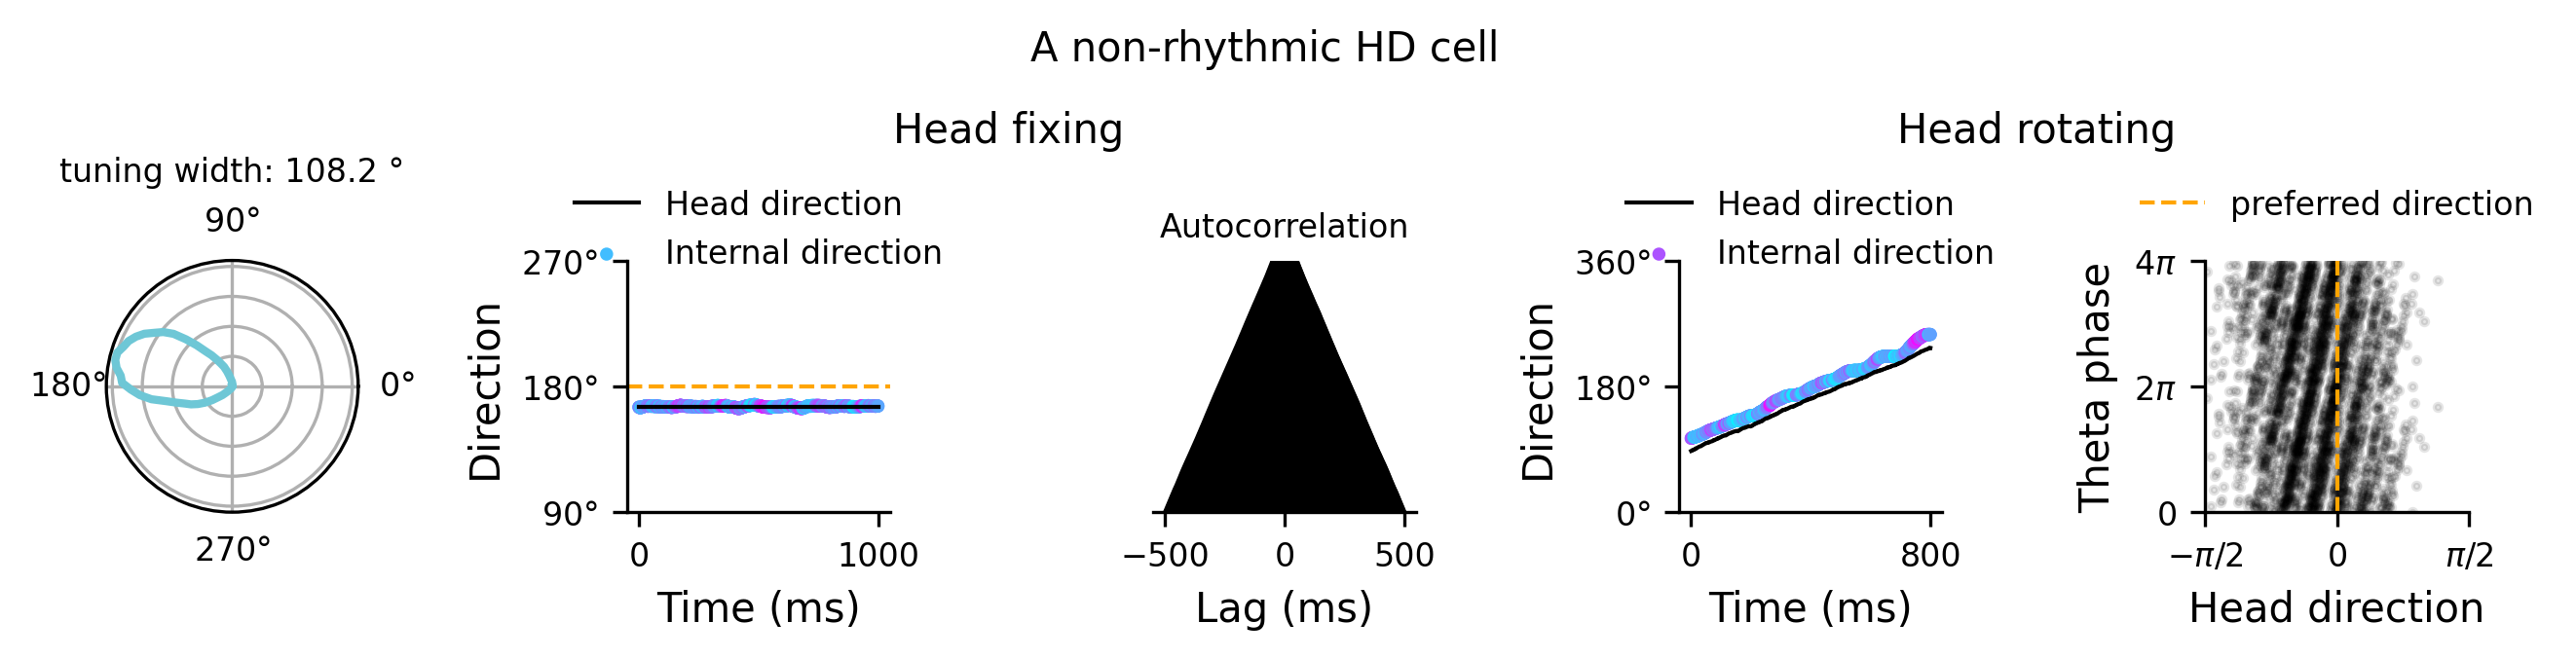

In [5]:
# 'theta_skipping', 'theta_non_skipping', 'non_theta_tuned
# cell_type = 'skipping'
# cell_type = 'non-skipping'
cell_type = 'non-rhythmic'

if cell_type == 'skipping':
    #theta skipping
    theta_modulation_stre_hd = 0.28; mbar_hd = 20
elif cell_type == 'non-skipping':
    #theta non-skipping
    theta_modulation_stre_hd = 2.5; mbar_hd = 0
elif cell_type == 'non-rhythmic':
    #non theta tuned
    theta_modulation_stre_hd = 0; mbar_hd = 20
else:
    raise ValueError('cell_type should be one of theta_skipping, theta_non_skipping, non_theta_tuned')

fig = plt.figure(figsize=(8.8, 2.6), dpi=300)

gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1])

labelsize = 10
ticksize = 8
s_size = 1

results = run(theta_modulation_stre_hd=theta_modulation_stre_hd, mbar_hd=mbar_hd, angular_velocity_gain=1)
start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

#plot HD tuning map
ax = fig.add_subplot(gs[0], polar=True)
cellindex = 50; num_hd = 100
tuningmap = get_HDtuningMap(HD_activity, Head_direction, cellindex, filter=False, samples_per_sec=1, dim=num_hd)
#find the width of the tuning map
width, _ = compute_gaussian_width(tuningmap)
#rad to degree
width = width*180/np.pi
ax = plot_HD_tuningMap(ax, tuningmap, ticksize=ticksize)
ax.set_title(f'tuning width: {width:.1f} °', fontsize=ticksize)

###################################################################################

#plot the sweeps
ax = fig.add_subplot(gs[3])
ax = plot_HDsweep(ax, 
                  time_steps[start:end], 
                  Head_direction[start:end], 
                  center_HD[start:end], 
                  max_bump_activity[start:end])

#plot phase precession
ax = fig.add_subplot(gs[4])
ax = plot_phase_precession(ax, cellindex, HD_activity, Head_direction, theta_phase, ticksize=ticksize)

#add text aboce gs 1 and gs 2, in the middle bewteen gs 1 and gs 2
fig.text(0.8, 0.7, 'Head rotating', ha='center', fontsize=labelsize)

results = run(theta_modulation_stre_hd=theta_modulation_stre_hd, mbar_hd=mbar_hd, angular_velocity_gain=0)

start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

#plot the sweeps
ax = fig.add_subplot(gs[1])

ax = plot_HDsweep(ax, 
                  time_steps[start:end], 
                  Head_direction[start:end], 
                  center_HD[start:end], 
                  max_bump_activity[start:end])

#add y=0
ax.axhline(y=0, color='orange', linestyle='--', linewidth=1)
ax.set_ylim(-np.pi/2, bm.pi/2)
ax.set_yticks([-np.pi/2, 0, np.pi/2])
ax.set_yticklabels([r'$90\degree$', r'$180\degree$', r'$270\degree$'])

#plot the sweeps
ax = fig.add_subplot(gs[2])

probe_index = 50
r_probe = HD_activity[:, probe_index]

autocorr_r_probe =  compute_autocorrelation(r_probe, bin_size=0.001, max_lag=0.5)

ax = plot_autocorrelation(ax, autocorr_r_probe, labelsize=labelsize, ticksize=ticksize)


#add text aboce gs 1 and gs 2, in the middle bewteen gs 1 and gs 2
fig.text(0.4, 0.7, 'Head fixing', ha='center', fontsize=labelsize)

#sup title
if cell_type == 'skipping':
    title = r'$\theta$-skipping'
elif cell_type == 'non-skipping':
    title = r'non-$\theta$-skipping'
elif cell_type == 'non-rhythmic':
    title = 'non-rhythmic'
fig.suptitle('A '+ title + ' HD cell', fontsize=labelsize, y=0.85)

plt.tight_layout()

plt.savefig('./figures/HD_phaseprecession_'+cell_type+'.pdf', dpi=300)

#### check tuning field width

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

mean tuning width of non-rhythmic: 114.91898528530122
mean tuning width of non-theta-skipping: 116.0417702829502
mean tuning width of theta-skipping: 120.83616003981305
Statistics=3.000, p=0.000
Statistics=0.000, p=0.000
Statistics=0.000, p=0.000


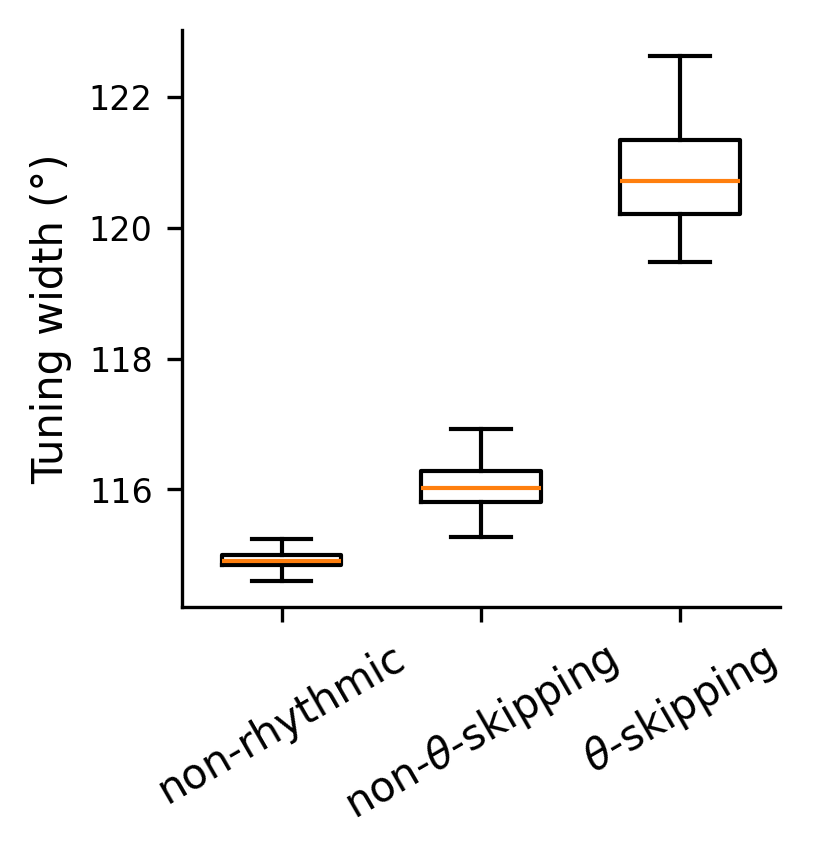

In [10]:
## Add significance lines and annotations
def add_significance_line(x1, x2, y, text, ax):
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.0)
    ax.text((x1 + x2) * .5, y + 0.2, text, ha='center', va='bottom', color='black', fontsize=8)

theta_modulation_stre_hds = [0, 2.5, 0.28] 
mbar_hds = [0, 0, 20]
tuning_widths_all = []

for theta_modulation_stre_hd, mbar_hd in zip(theta_modulation_stre_hds, mbar_hds):

    results = run(theta_modulation_stre_hd=theta_modulation_stre_hd, mbar_hd=mbar_hd, angular_velocity_gain=1)
    start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

    #get all tuning width for all cells
    tuning_widths = []
    for i in range(num_hd):
        tuningmap = get_HDtuningMap(HD_activity, Head_direction, i, filter=False, samples_per_sec=1, dim=num_hd)
        width, _ = compute_gaussian_width(tuningmap)
        tuning_widths.append(width*180/np.pi)
    tuning_widths_all.append(tuning_widths)
    
#box plot of the three tuning width
fig, ax  = plt.subplots(1, 1, figsize=(2.8, 3), dpi=300)
labelsize = 10
ticksize = 8
#box plot without showing outliers
ax.boxplot(tuning_widths_all, positions=[0, 1, 2], widths=0.6, showfliers=False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['non-rhythmic', r'non-$\theta$-skipping', r'$\theta$-skipping'], fontsize=labelsize, rotation=30)
ax.set_ylabel('Tuning width (°)', fontsize=labelsize)
#print the mean of three groups
print('mean tuning width of non-rhythmic:', np.mean(tuning_widths_all[0]))
print('mean tuning width of non-theta-skipping:', np.mean(tuning_widths_all[1]))
print('mean tuning width of theta-skipping:', np.mean(tuning_widths_all[2]))

#ticksize
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

stat, p = mannwhitneyu(tuning_widths_all[0], tuning_widths_all[1])
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = mannwhitneyu(tuning_widths_all[0], tuning_widths_all[2])
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = mannwhitneyu(tuning_widths_all[1], tuning_widths_all[2])
print('Statistics=%.3f, p=%.3f' % (stat, p))

plt.tight_layout()

plt.savefig('./figures/HD_tuningwidth.pdf', dpi=300)
    

### check the skipping index versus offset angle value

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

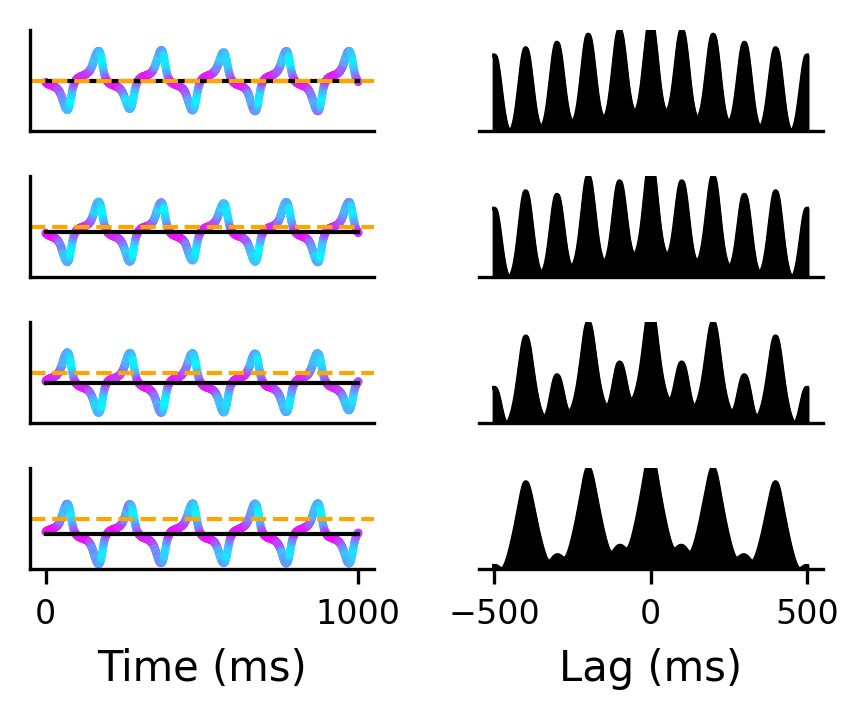

In [7]:

fig = plt.figure(figsize=(3, 2.5), dpi=300)


offset_all = np.arange(0, -0.20, -0.05)

gs = gridspec.GridSpec(len(offset_all), 2)

for i, offset in enumerate(offset_all):

    results = run(theta_modulation_stre_hd=theta_modulation_stre_hd, mbar_hd=mbar_hd, angular_velocity_gain=0, offset=offset)

    start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

    #plot the sweeps
    ax = fig.add_subplot(gs[i, 0])

    ax = plot_HDsweep(ax, 
                    time_steps[start:end], 
                    Head_direction[start:end], 
                    center_HD[start:end], 
                    max_bump_activity[start:end],
                    s_size=1)
    #legend off
    ax.legend().set_visible(False)
    ax.set_ylabel('')

    #add y=0
    ax.axhline(y=0, color='orange', linestyle='--', linewidth=1)
    ax.set_ylim(-np.pi/2, bm.pi/2)
    ax.set_yticks([])


    if i != len(offset_all)-1:
        ax.set_xticks([])
        ax.set_xlabel('')

    #plot autocorrelation
    ax = fig.add_subplot(gs[i, 1])

    probe_index = 50 #always probe the neuron at 50, corresponding to offset = 0
    r_probe = HD_activity[:, probe_index]

    autocorr_r_probe =  compute_autocorrelation(r_probe, bin_size=0.001, max_lag=0.5)

    ax = plot_autocorrelation(ax, autocorr_r_probe, labelsize=labelsize, ticksize=ticksize)
    
    ax.set_title('')
    
    if i != len(offset_all)-1:
        ax.set_xticks([])
        ax.set_xlabel('')
    
plt.tight_layout()

plt.savefig('./figures/HD_skipping_offset_examples.pdf', dpi=300)


### plot the skipping index versus offset for both skipping and non-skipping cells

In [8]:

theta_modulation_stre_hd = 2.5
mbar_hd = 0
offset_all = np.arange(0, -0.5, -0.1)
N=20 #run 20 times for each offset
SkipIndex_skip = np.zeros((len(offset_all),N))
SkipIndex_nonskip = np.zeros((len(offset_all),N))
                             
for i, offset in enumerate(offset_all):
    
    #run 20 times for each offset
    
    for j in range(N):

        #skipping cells
        results = run(theta_modulation_stre_hd=0.28, mbar_hd=20, angular_velocity_gain=0, offset=offset)

        start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

        probe_index = 50 #always probe the neuron at 50, corresponding to offset = 0
        r_probe = HD_activity[:, probe_index]

        autocorr_r_probe =  compute_autocorrelation(r_probe, bin_size=0.001, max_lag=0.5)
        
        #calculate skipping index
        omega, TS = calculate_skipping_index(autocorr_r_probe)
        
        SkipIndex_skip[i,j] = TS
        
        ###########################################################################
        #non-skipping cells
        results = run(theta_modulation_stre_hd=2.5, mbar_hd=0, angular_velocity_gain=0, offset=offset)
        
        start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results
        
        probe_index = 50 #always probe the neuron at 50, corresponding to offset = 0
        r_probe = HD_activity[:, probe_index]
        
        autocorr_r_probe =  compute_autocorrelation(r_probe, bin_size=0.001, max_lag=0.5)
        
        #calculate skipping index
        omega, TS = calculate_skipping_index(autocorr_r_probe)
        
        SkipIndex_nonskip[i,j] = TS
        
#for plotting
offset_all = np.abs(offset_all)
offset_all = offset_all*180/np.pi
offset_all = [int(offset) for offset in offset_all]  

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

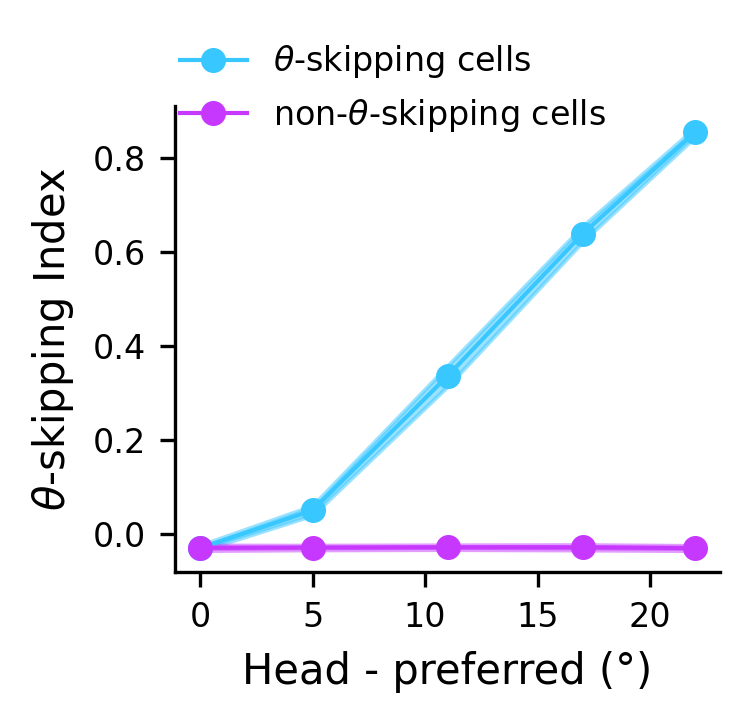

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2.6, 2.6), dpi=300)

#skipping
mean_skipindex = np.mean(SkipIndex_skip, axis=1)
std_skipindex = np.std(SkipIndex_skip, axis=1)
ax.plot(offset_all, mean_skipindex, color='#38c7ff', marker='o', markersize=5, linewidth=1, label=r'$\theta$-skipping cells')
ax.fill_between(offset_all, mean_skipindex-std_skipindex, mean_skipindex+std_skipindex, color='#38c7ff', alpha=0.5)

#non-skipping
mean_skipindex = np.mean(SkipIndex_nonskip, axis=1)
std_skipindex = np.std(SkipIndex_nonskip, axis=1)
ax.plot(offset_all, mean_skipindex, color='#c738ff', marker='o', markersize=5, linewidth=1, label=r'non-$\theta$-skipping cells')
ax.fill_between(offset_all, mean_skipindex-std_skipindex, mean_skipindex+std_skipindex, color='#c738ff', alpha=0.5)

ax.legend(fontsize=ticksize, frameon=False, bbox_to_anchor=(0.4, 1.2), loc='upper center')

ax.set_xlabel('Head - preferred (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
#ticks as degrees
# ax.set_xticks([offset_all[i]*180/np.pi for i in range(0, len(offset_all), 2)])

#ticksize
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/HD_skipping_offset.pdf', dpi=300)

